In [ ]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from scipy.stats import mannwhitneyu, ks_2samp
import os

In [ ]:
def get_true_drift(config, prev_paths):
    if "fOU" in config.data_path:
        try:
            return -config.mean_rev * (prev_paths.numpy())
        except AttributeError as e:
            return -config.mean_rev * (prev_paths)

    elif "fSin" in config.data_path:
        try:
            return config.mean_rev * np.sin(prev_paths.numpy())
        except AttributeError as e:
            return config.mean_rev * np.sin(prev_paths)


In [ ]:
from configs.RecursiveVPSDE.recursive_fSin_T256_H05_tl_5data import get_config as get_config_postmean
config_postmean = get_config_postmean()
if "fOU" in config_postmean.data_path:
    assert (config_postmean.mean == 0.)
rng = np.random.default_rng()
num_simulated_paths = 500
data_shape = (num_simulated_paths, 1, 1)
device = "cpu"

real_time_scale = torch.linspace(start=1 / config_postmean.ts_length, end=1, steps=config_postmean.ts_length).to(device)

max_diff_steps = config_postmean.max_diff_steps
sample_eps = config_postmean.sample_eps
mean_rev = config_postmean.mean_rev
ts_step = 1 / config_postmean.ts_length
eval_ts_length = 256

In [4]:
from scipy.stats import wasserstein_distance
import ot
def bootstrap_test_wasserstein(sample1, sample2, num_bootstrap=1000):
    # Step 1: Compute the observed Wasserstein distance
    M = ot.dist(sample1, sample2, metric='euclidean')
    a = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for X
    b = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for Y

    #observed_distance = wasserstein_distance(sample1, sample2)
    print(a.shape, b.shape, M.shape)
    observed_distance = ot.lp.emd2(a, b, M = M)
    # Step 2: Bootstrap samples
    bootstrap_distances = []
    combined = np.vstack([sample1, sample2])
    for _ in range(num_bootstrap):
        np.random.shuffle(combined)
        obs_perm = combined[:sample1.shape[0], :]
        sim_perm = combined[sample2.shape[0]:, :]

        # Step 3: Compute Wasserstein distance for bootstrap samples
        M = ot.dist(obs_perm, sim_perm, metric='euclidean')
        boot_distance = (ot.lp.emd2(a, b, M = M))
        #boot_distance = wasserstein_distance(boot_sample1, boot_sample2)
        bootstrap_distances.append(boot_distance)

    # Step 4: Calculate p-value and confidence intervals
    bootstrap_distances = np.array(bootstrap_distances)
    p_value = np.mean(bootstrap_distances >= observed_distance)
    print(bootstrap_distances, observed_distance, p_value)

    return observed_distance, p_value

# Plot the generated paths and compare with exact paths

(500,) (500,) (500, 500)
[4.28132133 4.21375738 4.21848405 4.16398061 4.24704013 4.15742359
 4.31028651 4.27378906 4.36523562 4.24895452 4.14277783 4.24577647
 4.19499677 4.16069095 4.8089911  4.38659882 4.10573334 4.36521911
 4.17911974 4.55535349 4.26258679 4.1530274  4.15996064 4.32822219
 4.30510396 4.18309606 4.28647803 4.19196667 4.15122018 4.19615949
 4.14891526 4.177394   4.25593033 4.22317239 4.36460393 4.22021087
 4.18414644 4.15863587 4.35576896 4.07381938 4.23123661 4.20445438
 4.43757957 4.19780236 4.28334782 4.63182181 4.30970116 4.28344005
 4.23381375 4.28864292 4.71133103 4.15579383 4.19575368 4.47382582
 4.18881034 4.33153276 4.24558303 4.36063935 4.12362915 4.10273082
 4.19675119 4.18403093 4.44167284 4.15020392 4.14589451 4.18534353
 4.22674532 4.13045554 4.50091695 4.35707493 4.30252128 4.33382284
 4.33559918 4.1990532  4.47433356 4.14381951 4.20972876 4.21803969
 4.14665302 4.32024706 4.09542831 4.29615951 4.17839479 4.16541667
 4.11559398 4.20083695 4.6191002  4.2

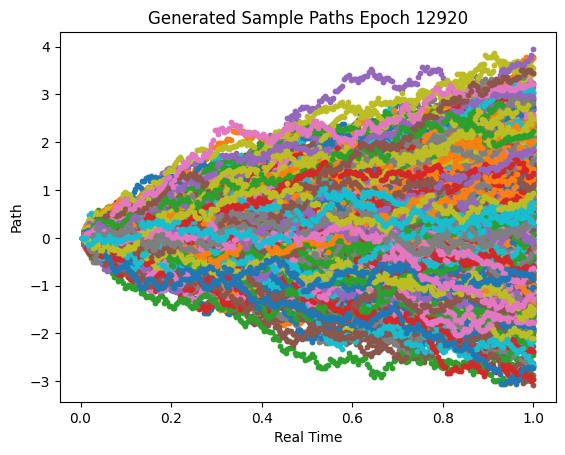

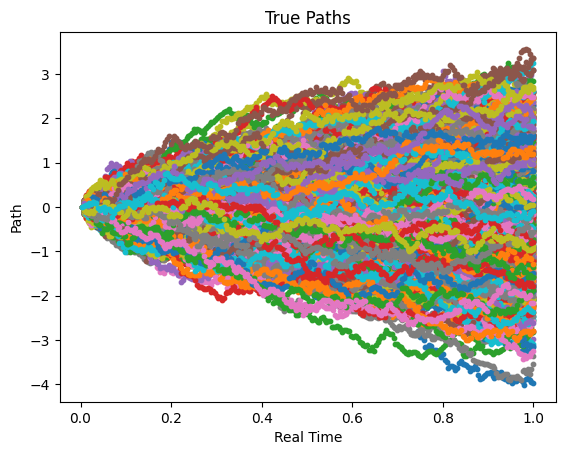

In [15]:
# Plot the drift estimator for different sample paths across time
for Nep in [960]:
    save_path = project_config.ROOT_DIR + f"experiments/results/TS_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_{config_postmean.mean_rev}MeanRev_{config_postmean.max_diff_steps}DiffSteps".replace(".", "")
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths")
        synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), postMean_prevPaths.shape[0], replace=False),:]
        synthetic_paths = np.concatenate([np.zeros((synthetic_paths.shape[0], 1)), synthetic_paths[:,:-1]], axis=1)
        synthetic_paths = synthetic_paths[:,:postMean_prevPaths.shape[1]]
        print(bootstrap_test_wasserstein(postMean_prevPaths.numpy(), synthetic_paths)[1])
        for pathid in range(num_simulated_paths):
            plt.scatter(real_time_scale[:eval_ts_length].cpu(), postMean_prevPaths[pathid,:].cpu(), s=10)
        plt.xlabel("Real Time")
        plt.ylabel("Path")
        plt.title(f"Generated Sample Paths Epoch {Nep}")
        plt.show()
        plt.close()
        for pathid in range(num_simulated_paths):
            plt.scatter(real_time_scale[:eval_ts_length].cpu(), synthetic_paths[pathid,:], s=10)
        plt.xlabel("Real Time")
        plt.ylabel("Path")
        plt.title(f"True Paths")
        plt.show()
        plt.close()
        del postMean_prevPaths
    except FileNotFoundError as e:
        print(e)
        pass

In [6]:
# Plot some marginal distributions for increments
time_space = np.linspace((1. / config_postmean.ts_length), 1., num=config_postmean.ts_length)
low = 0
high = config_postmean.ts_length
Nep = [960][0]
save_path = project_config.ROOT_DIR + f"experiments/results/TS_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_{config_postmean.mean_rev}MeanRev_{config_postmean.max_diff_steps}DiffSteps".replace(".", "")
postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), postMean_prevPaths.shape[0], replace=False),:]
synthetic_paths = np.concatenate([np.zeros((synthetic_paths.shape[0], 1)), synthetic_paths[:,:-1]], axis=1)

# Plot evolution of marginal density of increments


In [7]:
incs = np.diff(postMean_prevPaths, axis=1)[1:]
synth_incs = np.diff(synthetic_paths, axis=1)[1:]

fig, ax = plt.subplots(figsize=(10, 8))
# Initialize empty bars
_ = ax.hist([], bins=30, color='blue', alpha=0.6, label='True', edgecolor='black')[2]
_ = ax.hist([], bins=30, color='orange', alpha=0.6, label='Synthetic', edgecolor='black')[2]

# Set axis labels and title
ax.set_xlabel('Increment Value', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
ax.tick_params(axis='y', labelsize=18)
ax.set_title(f"Marginal Distributions for Increment", fontsize=20)
ax.legend(loc="upper right", fontsize=20)

def update(frame):
    ax.clear()  # Clear the previous histogram
    # Plot true histogram
    ax.hist(incs[:,frame], bins=50, color="blue", density=True, alpha=0.5, label='Generated')
    # Plot synthetic histogram
    ax.hist(synth_incs[:, frame], bins=50, color="orange",density=True, alpha=0.5, label='True')
    print(ks_2samp(incs[:,frame], synth_incs[:, frame])[1], mannwhitneyu(incs[:,frame], synth_incs[:, frame])[1])
    ax.set_xlabel('Increment Value', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)
    ax.set_title(f"Marginal Distributions for Increments at Time {frame + 1}", fontsize=20)
    ax.legend(loc="upper right", fontsize=20)

ani = FuncAnimation(fig, update, frames=range(1, eval_ts_length, 50), interval=1000/1, repeat=False)

plt.close(fig)
display(HTML(ani.to_jshtml()))  # Converts animation to JavaScript HTML5 format

0.3281883761340614 0.33980712150074566
0.3281883761340614 0.33980712150074566
0.9599558766898113 0.7671751549030705
0.5076130149854423 0.2633040138206296
0.4122246460022909 0.42528514093558123
0.2565588083481409 0.21099359279630758
0.9958971937331182 0.6174577238727657


# Plot the marginal density of the path values


In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
# Initialize empty bars
_ = ax.hist([], bins=30, color='blue', alpha=0.6, label='True', edgecolor='black')[2]
_ = ax.hist([], bins=30, color='orange', alpha=0.6, label='Synthetic', edgecolor='black')[2]

# Set axis labels and title
ax.set_xlabel('Path Value', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
ax.tick_params(axis='y', labelsize=18)
ax.set_title(f"Marginal Distributions for Paths", fontsize=20)
ax.legend(loc="upper right", fontsize=20)

def update(frame):
    ax.clear()  # Clear the previous histogram
    # Plot true histogram
    ax.hist(postMean_prevPaths[:,frame], bins=50, color="blue", density=True, alpha=0.5, label='Generated')
    # Plot synthetic histogram
    ax.hist(synthetic_paths[:, frame], bins=50, color="orange",density=True, alpha=0.5, label='True')
    print(ks_2samp(postMean_prevPaths[:,frame], synthetic_paths[:, frame])[1], mannwhitneyu(postMean_prevPaths[:,frame], synthetic_paths[:, frame])[1])
    ax.set_xlabel('Path Value', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)
    ax.set_title(f"Marginal Distributions for Paths at Time {frame + 1}", fontsize=20)
    ax.legend(loc="upper right", fontsize=20)

ani = FuncAnimation(fig, update, frames=range(1, eval_ts_length, 50), interval=1000/1, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())  # Converts animation to JavaScript HTML5 format

0.3699050405997647 0.22570214211774187
0.3699050405997647 0.22570214211774187
0.9026912216773312 0.8768780485149409
0.5600220048872044 0.7079843503367483
0.7704365372945415 0.7235176434864516
0.2919248807417811 0.08327020906977904
0.12939616996710074 0.022861271329888008


# Check if generated true drift agrees with what we expect

In [ ]:
for Nep in [960]:
    save_path = project_config.ROOT_DIR + f"experiments/results/TS_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_{config_postmean.mean_rev}MeanRev_{config_postmean.max_diff_steps}DiffSteps".replace(".", "")
    try:
        print(save_path)
        postMean_prevPaths = torch.load(save_path + "_prevPaths")
        true_drift = torch.load(save_path + "_driftTrue")
        for diffTime in range(0, config_postmean.max_diff_steps, 2500):
            plt.scatter(postMean_prevPaths, get_true_drift(config_postmean, postMean_prevPaths), s=10, color="orange",label="True")
            plt.scatter(postMean_prevPaths, true_drift[:,:,config_postmean.max_diff_steps-1-diffTime],alpha=0.05, s=10,color="blue")
            plt.title(f"True Drift Check at Diff Time {config_postmean.max_diff_steps-1-diffTime}")
            plt.legend()
            plt.show()
    except FileNotFoundError as e:
        pass

In [10]:
# Compute and store MSE for estimated drifts
experiment_emses = {Nep: None for Nep in [960]}
minbiasses = {Nep: None for Nep in [960]}
for Nep in [960]:
    save_path = project_config.ROOT_DIR + f"experiments/results/TS_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_{config_postmean.mean_rev}MeanRev_{config_postmean.max_diff_steps}DiffSteps".replace(".", "")
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths")
        drift_est = torch.load(save_path + "_driftEst").numpy()
        true_drift = get_true_drift(config_postmean,postMean_prevPaths)
        bias2 = np.power(true_drift[:,:, np.newaxis] - drift_est,2).mean(axis=0)
        #variance = torch.var(drift_est, axis=0)
        del drift_est, postMean_prevPaths, true_drift
        emses = bias2 #+ variance
        experiment_emses[Nep] = emses
        minbiasses[Nep] = np.argmin(emses, axis=1)
    except FileNotFoundError as e:
        print(e)
        pass

# Plot the drift estimates as a function of state (X)

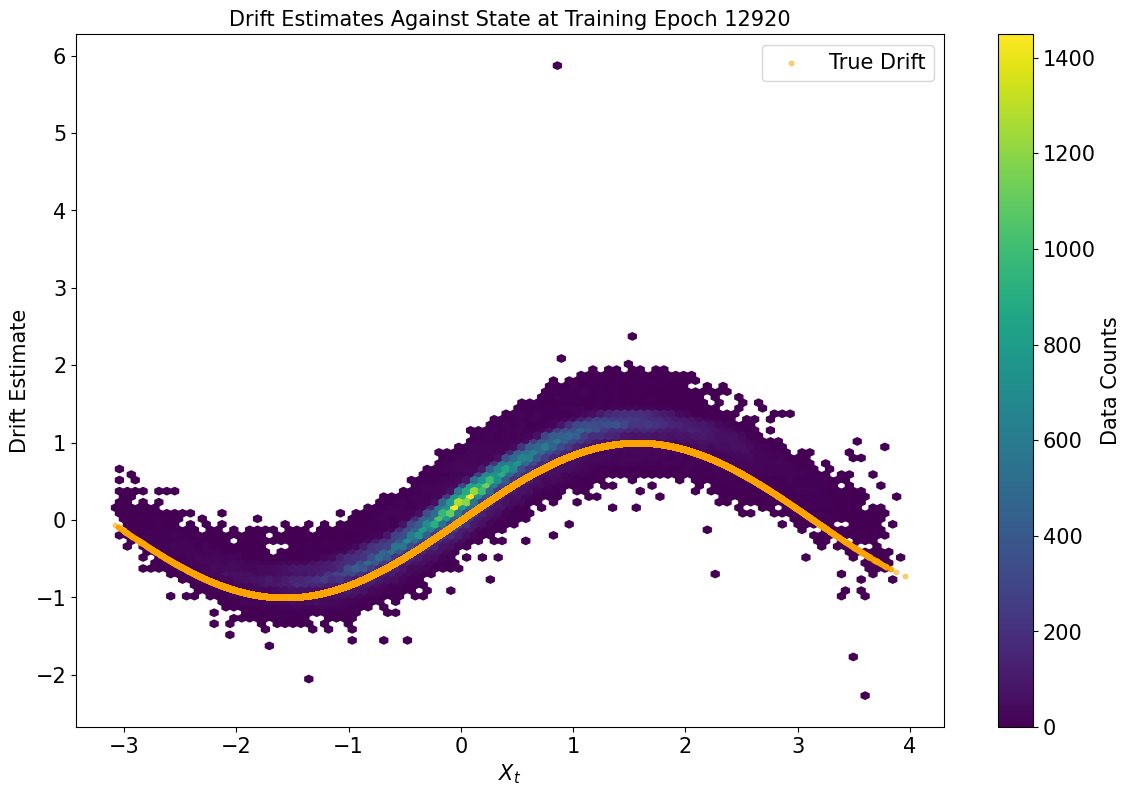

In [9]:
fig, ax = plt.subplots(figsize=(14, 9))
for Nep in [960]:
    save_path = project_config.ROOT_DIR + f"experiments/results/TS_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_{config_postmean.mean_rev}MeanRev_{config_postmean.max_diff_steps}DiffSteps".replace(".", "")
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
        drift_est = torch.load(save_path + "_driftEst").numpy()
        true_drift = get_true_drift(config_postmean, postMean_prevPaths)
        num_bins = 100
        total_counts = None
        combined_x = []
        combined_y = []
        # Accumulate data for all time steps
        for t in range(1, eval_ts_length):
            x_data = postMean_prevPaths[:, t]
            y_data = drift_est[:, t, minbiasses[Nep][t]]

            # Append data points for all time points
            combined_x.extend(x_data)
            combined_y.extend(y_data)

        # Accumulate total counts from hexbin
        hb = ax.hexbin(combined_x, combined_y, gridsize=num_bins, cmap='viridis', mincnt=1)
        total_counts = hb.get_array()

        # Set color limits based on the total counts
        hb.set_clim(0, np.max(total_counts))

        # Create the colorbar for the combined counts
        cbar = plt.colorbar(hb, ax=ax)
        cbar.ax.tick_params(labelsize=18)
        cbar.set_label('Data Counts', fontsize=20)

        # Plot the true drift scatter plot
        plt.scatter(postMean_prevPaths, true_drift, s=10, alpha=0.5, color="orange", label="True Drift")
        plt.legend(fontsize=20)
        plt.title(f"Drift Estimates Against State at Training Epoch {Nep}", fontsize=20)
        plt.xlabel("$X_{t}$", fontsize=20)
        plt.ylabel("Drift Estimate", fontsize=20)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)

        plt.show()
        plt.close()

        del drift_est
    except FileNotFoundError as e:
        pass

# Plot the drift as a function of state for different SDE times

In [ ]:
Nep = [960][0]
save_path = project_config.ROOT_DIR + f"experiments/results/TS_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_{config_postmean.mean_rev}MeanRev_{config_postmean.max_diff_steps}DiffSteps".replace(".", "")
fig, ax = plt.subplots(figsize=(10, 8))
postMean_prevPaths = torch.load(save_path + "_prevPaths")
drift_est = torch.load(save_path + "_driftEst")
true_drift = get_true_drift(config_postmean, postMean_prevPaths)

# Create initial hexbin plot to get the color mapping
hb = ax.hexbin(postMean_prevPaths[:, 0], drift_est[:, 0, minbiasses[Nep][0]], mincnt=1, cmap='viridis')
cbar = plt.colorbar(hb, ax=ax)  # Create colorbar based on initial hexbin plot
cbar.ax.tick_params(labelsize=15)  # Set colorbar tick font size
cbar.set_label('Number of Samples', fontsize=15)   # Set colorbar label font size

def update(frame):
    ax.clear()  # Clear the previous histogram
    hb = ax.hexbin(postMean_prevPaths[:, frame], drift_est[:,frame, minbiasses[Nep][frame]] - 0.05, mincnt=1)

    cbar.mappable.set_array(hb.get_array())  # Update colorbar with the current hexbin data
    fig.draw_without_rendering()
    ax.scatter(postMean_prevPaths[:, frame], true_drift[:, frame], s=20, alpha=0.5, color="orange", label=rf"True Drift $\sin(\tilde{{X}}_{{t_{{{frame}}}}})$")

    ax.legend(fontsize=15)

    ax.set_title(rf"Drift Estimator $\hat{{\mu}}({{t_{{{frame}}}}}, \tilde{{X}}_{{t_{{{frame}}}}}, \tau^*, Z_{{\tau^*}})$ Against $ \tilde{{X}}_{{t_{{{frame}}}}}$", fontsize=20)
    ax.set_xlabel(rf"$\tilde{{X}}_{{t_{{{frame}}}}}$", fontsize=20)
    ax.set_ylabel(rf"Drift Value at time ${{t_{{{frame}}}}}$", fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)

ani = FuncAnimation(fig, update, frames=range(1, eval_ts_length, 30), interval=1000/1, repeat=False)
#ani.save("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/gif2.gif", writer="pillow")
plt.close(fig)
display(HTML(ani.to_jshtml()))  # Converts animation to JavaScript HTML5 format

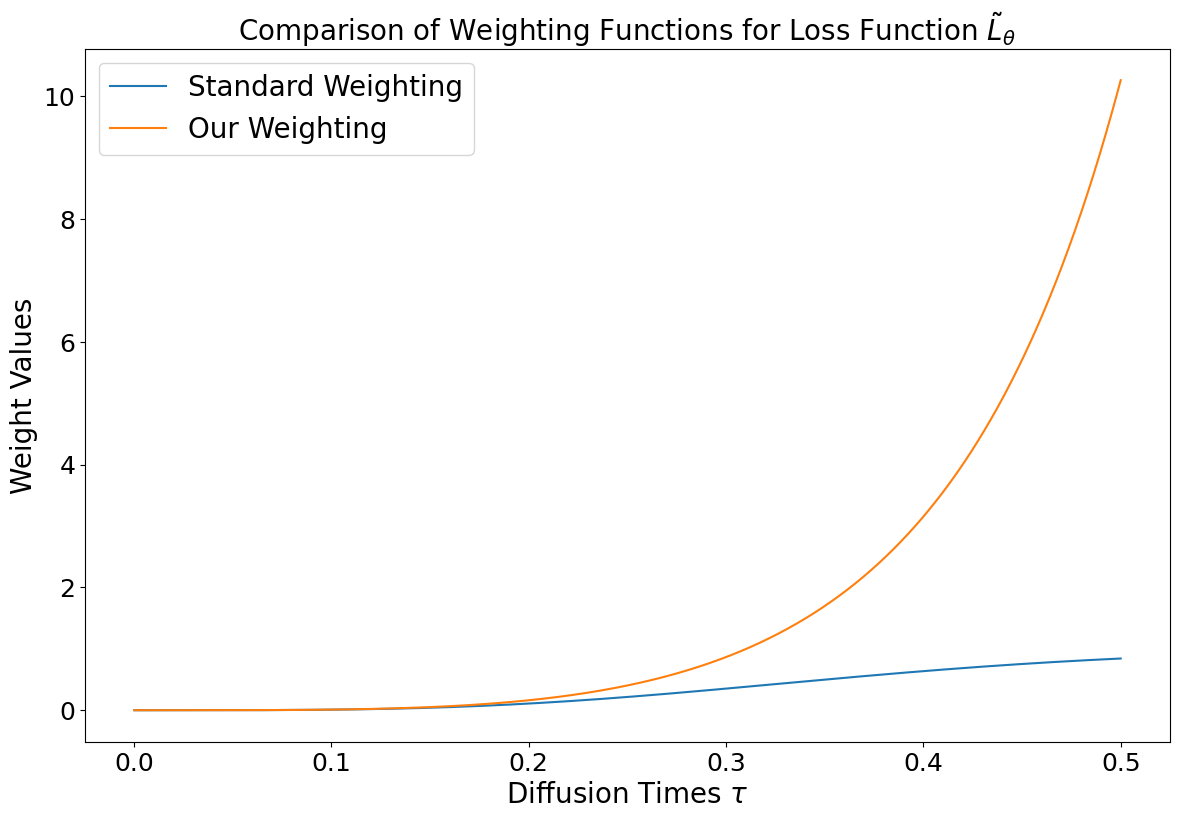

In [45]:
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
taus = torch.linspace(config_postmean.train_eps, end=config_postmean.end_diff_time,
                                       steps=config_postmean.max_diff_steps)
diffusion = VPSDEDiffusion(beta_max=config_postmean.beta_max, beta_min=config_postmean.beta_min)
eff_times = diffusion.get_eff_times(taus)
# For times larger than tau0, use inverse_weighting
sigma_tau = 1. - torch.exp(-eff_times).numpy().flatten()
beta_tau = torch.exp(-0.5 * eff_times).numpy().flatten()
my_weights = np.power(sigma_tau / beta_tau, 2).flatten()
normal_weights = np.power(sigma_tau, 2).flatten()
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(taus[:config_postmean.max_diff_steps//2], normal_weights[:config_postmean.max_diff_steps//2], label="Standard Weighting")
ax.plot(taus[:config_postmean.max_diff_steps//2], my_weights[:config_postmean.max_diff_steps//2], label="Our Weighting")
ax.legend(fontsize=20)

ax.set_title(r"Comparison of Weighting Functions for Loss Function $\tilde{L}_{\theta}$ ", fontsize=20)
ax.set_xlabel(rf"Diffusion Times $\tau$", fontsize=20)
ax.set_ylabel(rf"Weight Values", fontsize=20)
ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
ax.tick_params(axis='y', labelsize=18)
plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/weightingfunctions.png")
plt.show()
plt.close()

# Compare the density of the true drift values against the estimated drifts

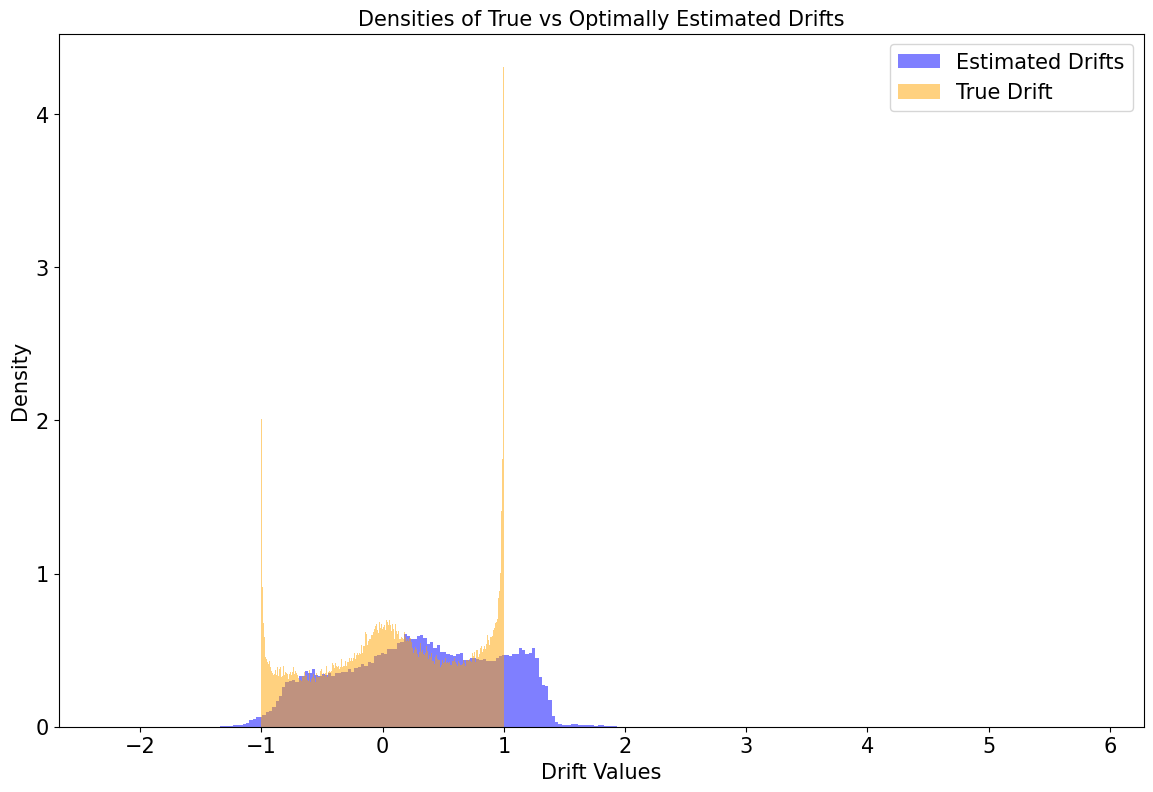

In [14]:
for Nep in [960]:
    save_path = (project_config.ROOT_DIR + f"experiments/results/TS_ES0_fSin_DriftEvalExp_{Nep}Nep_{config_postmean.loss_factor}LFactor_{config_postmean.mean_rev}MeanRev_{config_postmean.max_diff_steps}DiffSteps").replace(".", "")
    try:
        fig, ax = plt.subplots(figsize=(14, 9))
        postMean_prevPaths = torch.load(save_path + "_prevPaths").numpy()
        drift_est = torch.load(save_path + "_driftEst").numpy()
        opt_ests = []
        for t in range(eval_ts_length):
            curr_drift_est = drift_est[:, t, minbiasses[Nep][t]]
            assert(curr_drift_est.shape == (postMean_prevPaths.shape[0], ))
            opt_ests.append(curr_drift_est)
        plt.hist(np.concatenate(opt_ests).flatten(), bins=300, alpha=0.5, density=True, color="blue", label="Estimated Drifts")
        true_drift = get_true_drift(config_postmean, postMean_prevPaths)
        plt.hist(true_drift.flatten(), bins=300, alpha=0.5, density=True, color="orange", label="True Drift")
        ax.legend(fontsize=20)
        ax.set_xlabel("Drift Values", fontsize=20)
        ax.set_ylabel("Density", fontsize=20)
        ax.set_title("Densities of True vs Optimally Estimated Drifts", fontsize=20)
        ax.tick_params(labelsize=18)
        ax.tick_params(labelsize=18)
        plt.show()
        plt.close()
        del postMean_prevPaths, drift_est
    except FileNotFoundError as e:
        pass

# Plot the drift MSE across diffusion times and different real times

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_4930/2854754140.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


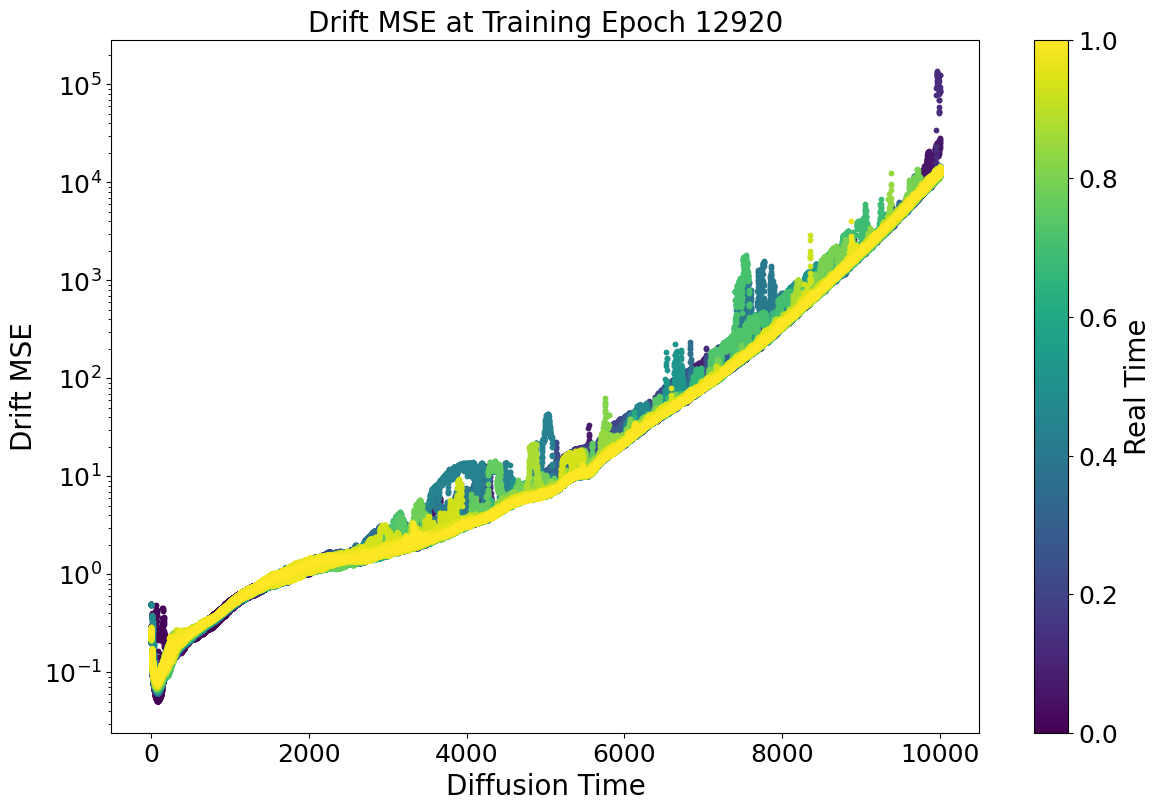

In [13]:
# Create a color map for 256 points
fig, ax = plt.subplots(figsize=(14,9))
min_drifts = {Nep: [] for Nep in [960]}
cmap = cm.viridis  # You can choose any color map
norm = plt.Normalize(vmin=0, vmax=1)
for Nepoch, values in experiment_emses.items():
    for t in range(eval_ts_length):
        plt.scatter(np.arange(0, config_postmean.max_diff_steps), values[t, :], s=10, color=cmap(t / (eval_ts_length - 1) ))
        min_drifts[Nepoch].append(np.min(values[t, :]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # We have to set the array to empty for ScalarMappable
    cbar = plt.colorbar(sm)
    cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size
    cbar.set_label('Real Time', fontsize=20)   # Set colorbar label font size
    plt.title(f"Drift MSE at Training Epoch {Nepoch}", fontsize=20)
    plt.xlabel("Diffusion Time", fontsize=20)
    plt.ylabel("Drift MSE", fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)
    plt.yscale("log")
    plt.show()
    plt.close()

# Plot the drift MSE across two real times

hi
12920 [[2.2894482e-01 2.2831149e-01 2.2717692e-01 ... 1.2952794e+04
  1.2938207e+04 1.2843318e+04]
 [2.3457183e-01 2.3405018e-01 2.3311651e-01 ... 1.2150962e+04
  1.2325752e+04 1.2340987e+04]
 [2.7728632e-01 2.7667111e-01 2.7556869e-01 ... 1.3164609e+04
  1.3016491e+04 1.3103266e+04]
 ...
 [2.4710830e-01 2.4654262e-01 2.4553043e-01 ... 1.4305923e+04
  1.3836995e+04 1.3936360e+04]
 [2.5835586e-01 2.5774348e-01 2.5664634e-01 ... 1.2598444e+04
  1.2481317e+04 1.2424225e+04]
 [2.6937968e-01 2.6878378e-01 2.6771659e-01 ... 1.2561307e+04
  1.2604789e+04 1.2871057e+04]]


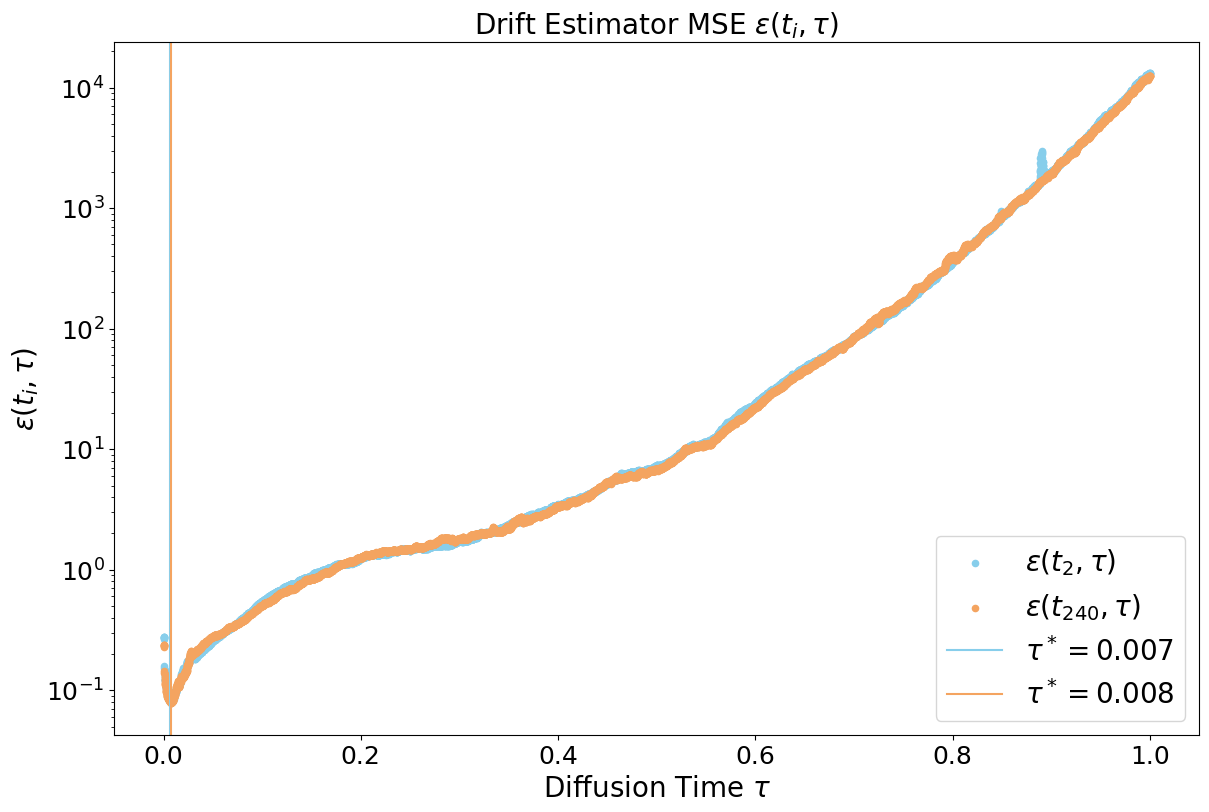

hi


In [16]:
# Create a color map for 256 points
print("hi")
fig, ax = plt.subplots(figsize=(14,9))
min_drifts = {Nep: [] for Nep in [960]}
taus = np.linspace(config_postmean.sample_eps, 1., config_postmean.max_diff_steps).flatten()
for Nepoch, values in experiment_emses.items():
    print(Nepoch, values)
    for t in range(2,eval_ts_length, 240):
        if t == 2:
            ax.scatter(taus, values[t, :],color="skyblue", s=20,label="$\epsilon(\mathit{t_{2}}, \\tau)$")
        else:
            ax.scatter(taus, values[t, :], color="sandybrown", s=20,label="$\epsilon(t_{240}, \\tau)$")
        min_drifts[Nepoch].append(np.min(values[t, :]))
    #ax.scatter(taus, epsilontaus, s=10, color=cmap(0 / (eval_ts_length - 1) ))
    ax.axvline(taus[np.argmin(values[2,:])], 0, max((np.max(values[2, :]), np.max(values[t, :]))), color="skyblue",label="$\\tau^*=$"+f"{round(taus[np.argmin(values[2,:])], 3)}" )
    ax.axvline(taus[np.argmin(values[t,:])], 0, max((np.max(values[2, :]), np.max(values[t, :]))),  color="sandybrown",label="$\\tau^*=$"+f"{round(taus[np.argmin(values[t,:])], 3)}" )
    plt.title("Drift Estimator MSE $\epsilon(\mathit{t_i},\\tau)$", fontsize=20)
    plt.xlabel("Diffusion Time $\\tau$", fontsize=20)
    plt.ylabel("$\epsilon(\mathit{t_i}, \\tau)$", fontsize=20)
    plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
    ax.tick_params(axis='y', labelsize=18)
    plt.yscale("log")
    #plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/diffusionerrortau2.png")
    plt.show()
    plt.close()
    print("hi")

# Plot the minimum drift MSE across real time

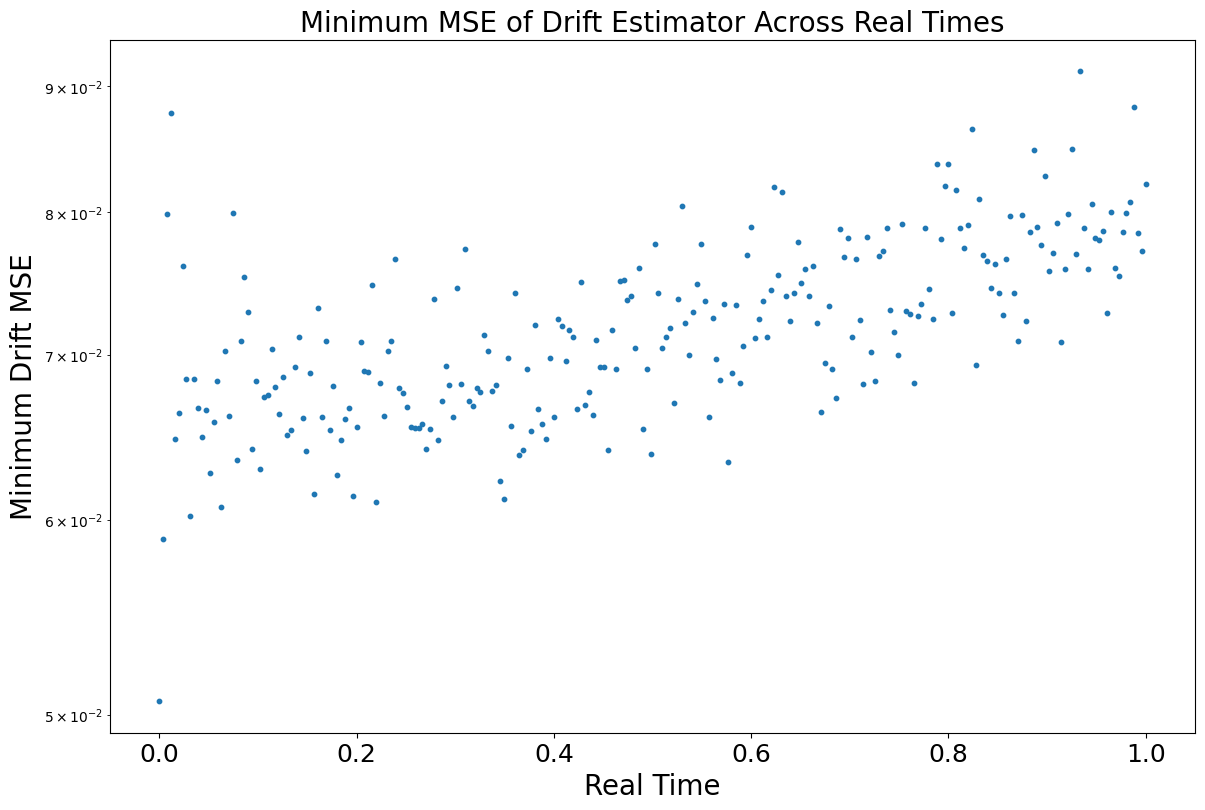

In [14]:
# Compute mean and bias2 for the drift estimates across different diffusion times
for Nepoch, values in min_drifts.items():
    try:
        fig, ax = plt.subplots(figsize=(14, 9))
        plt.scatter(np.linspace(0, 1., eval_ts_length), values, s=10, label=f"Epoch {Nepoch}")
        plt.title(f"Minimum MSE of Drift Estimator Across Real Times", fontsize=20)
        plt.xlabel("Real Time", fontsize=20)
        plt.ylabel("Minimum Drift MSE", fontsize=20)
        ax.tick_params(axis='x', labelsize=18)  # Set x-axis tick size to 12
        ax.tick_params(axis='y', labelsize=18)
        plt.yscale("log")
        plt.show()
        plt.close()
    except TypeError:
        pass